# Import libraries and prepare data

In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.express as px

In [3]:
# get the path to the data, not in the same location as the jupyter notebook
pathName = os.path.abspath(os.getcwd()) + "\\city-of-toronto-data\\"

fn_turn_restrict1718 = r"i0456_king_st_tmc_turn_restrictions2017_2018.csv"
fn_turn_restrict1923 = r"i0456_king_st_tmc_turn_restrictions2019_2023.csv"
fn_intersections = r"intersections_10-20.csv"

# create dataframes from csv
df_turn_restrict1718 = pd.read_csv(pathName + fn_turn_restrict1718, parse_dates=["dt_hourly"])
df_turn_restrict1923 = pd.read_csv(pathName + fn_turn_restrict1923, parse_dates=["dt_hourly"])
df_intersections = pd.read_csv(pathName + fn_intersections)

## Preparing data

In [4]:

# set dtypes
df_turn_restrict1718['e_thru_vol'] = df_turn_restrict1718['e_thru_vol'].apply(np.int64)
df_turn_restrict1923['e_left_vol'] = df_turn_restrict1923['e_left_vol'].astype('Int64')
df_turn_restrict1923['w_right_vol'] = df_turn_restrict1923['w_right_vol'].astype('Int64')

# merge to get intersection name
df_2017_2018 = pd.merge(df_turn_restrict1718, df_intersections[["intersection_uid", "intersection_name"]], on="intersection_uid")
df_2019_2023 = pd.merge(df_turn_restrict1923, df_intersections[["intersection_uid", "intersection_name"]], on="intersection_uid")

# create date and hour columns
df_2017_2018["date"] = df_2017_2018["dt_hourly"].apply(lambda x: x.date())
df_2017_2018["hour"] = df_2017_2018["dt_hourly"].apply(lambda x: x.hour)
df_2019_2023["date"] = df_2019_2023["dt_hourly"].apply(lambda x: x.date())
df_2019_2023["hour"] = df_2019_2023["dt_hourly"].apply(lambda x: x.hour)

## Filtering Data

### Taxi Mask

In [5]:
# Taxi Masks
TaxiMask1 = (df_2017_2018["hour"] >= 5) & (df_2017_2018["hour"] < 22)
df_2017_2018_nt = df_2017_2018[TaxiMask1].copy()

TaxiMask2 = (df_2019_2023["hour"] >= 5) & (df_2019_2023["hour"] < 22)
df_2019_2023_nt = df_2019_2023[TaxiMask2].copy()

### Intersection Filter

In [6]:
df_2017_2018_nt_Bathurst = df_2017_2018_nt[df_2017_2018_nt["intersection_uid"] == 10]
df_2019_2023_nt_Bathurst = df_2019_2023_nt[df_2019_2023_nt["intersection_uid"] == 10]

# Exploring Bathurst data

The intersection of King / Bathurst has the following restrictions:
- no EB thru traffic
- no WB thru traffic
- no WB left turns

## Temporal Masks

### Pre-Pilot

In [7]:
MaskPrePilot = (df_2017_2018_nt['dt_hourly'] >= '2017-10-01') & (df_2017_2018_nt['dt_hourly'] < '2017-11-12')
df_PrePilot_nt_Bathurst = df_2017_2018_nt_Bathurst.loc[MaskPrePilot].copy().reset_index(drop=True)

### Pilot (2017-2018)

In [8]:
MaskPilot = (df_2017_2018_nt['dt_hourly'] >= '2017-11-12') & (df_2017_2018_nt['dt_hourly'] < '2018-08-25')
df_Pilot_nt_Bathurst = df_2017_2018_nt_Bathurst.loc[MaskPilot].copy().reset_index(drop=True)

### 2019

In [9]:
Mask2019 = (df_2019_2023_nt['dt_hourly'] >= '2019-01-01') & (df_2019_2023_nt['dt_hourly'] < '2020-01-01')
df_2019_nt_Bathurst = df_2019_2023_nt_Bathurst.loc[Mask2019].copy().reset_index(drop=True)

### 2020

In [10]:
Mask2020 = (df_2019_2023_nt['dt_hourly'] >= '2020-01-01') & (df_2019_2023_nt['dt_hourly'] < '2021-01-01')
df_2020_nt_Bathurst = df_2019_2023_nt_Bathurst.loc[Mask2020].copy().reset_index(drop=True)

### 2021

In [11]:
Mask2021 = (df_2019_2023_nt['dt_hourly'] >= '2021-01-01') & (df_2019_2023_nt['dt_hourly'] < '2022-01-01')
df_2021_nt_Bathurst = df_2019_2023_nt_Bathurst.loc[Mask2021].copy().reset_index(drop=True)

### 2022

In [12]:
Mask2022 = (df_2019_2023_nt['dt_hourly'] >= '2022-01-01') & (df_2019_2023_nt['dt_hourly'] < '2023-01-01')
df_2022_nt_Bathurst = df_2019_2023_nt_Bathurst.loc[Mask2022].copy().reset_index(drop=True)

### 2023

In [13]:
Mask2023 = (df_2019_2023_nt['dt_hourly'] >= '2023-01-01') & (df_2019_2023_nt['dt_hourly'] < '2024-01-01')
df_2023_nt_Bathurst = df_2019_2023_nt_Bathurst.loc[Mask2023].copy().reset_index(drop=True)

## Aggregation

In [14]:
allmvmt = ["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"]
restrictedmvmtBathurst = ["e_thru_vol", "e_left_vol", "w_thru_vol"]
restrictedmvmtPortland = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtSpadina = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtPeter = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtJohn = ["e_left_vol", "w_left_vol"]
restrictedmvmtSimcoe = ["e_left_vol"]
restrictedmvmtUniversity = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtYork = ["w_left_vol"]
restrictedmvmtBay = ["e_left_vol", "w_left_vol"]
restrictedmvmtYonge = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtChurch = ["e_thru_vol", "e_left_vol", "w_thru_vol", "w_left_vol"]
restrictedmvmtJarvis = ["e_thru_vol", "w_thru_vol", "w_left_vol"]

### All Results

In [15]:
results1 = df_2017_2018_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
results1i = results1.reset_index()
results1i["date"] = pd.to_datetime(results1i["date"])

results2 = df_2019_2023_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
results2i = results2.reset_index()
results2i["date"] = pd.to_datetime(results2i["date"])

results = pd.concat([results1i, results2i])
results["year"] = results["date"].dt.year
results["doy"] = results["date"].dt.dayofyear
results

,date,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol,year,doy
0,2017-10-03,2386,453,457,1967,1075,467,2017,276
1,2017-10-04,4582,823,851,4715,2459,898,2017,277
2,2017-10-05,4733,830,804,4636,2299,863,2017,278
3,2017-10-06,4497,785,969,4505,2416,1030,2017,279
4,2017-10-10,4201,721,928,4543,2214,918,2017,283
...,...,...,...,...,...,...,...,...,...
1593,2023-05-27,964,43,1202,404,3213,1520,2023,147
1594,2023-05-28,434,31,722,336,2811,1280,2023,148
1595,2023-05-29,412,28,606,270,3261,1305,2023,149
1596,2023-05-30,583,44,810,362,3538,1646,2023,150


### Pre-Pilot

In [16]:
resultPrePilot = df_PrePilot_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
resultPrePilot

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2017-10-03,2386,453,457,1967,1075,467
2017-10-04,4582,823,851,4715,2459,898
2017-10-05,4733,830,804,4636,2299,863
2017-10-06,4497,785,969,4505,2416,1030
2017-10-10,4201,721,928,4543,2214,918
2017-10-11,4539,819,963,4965,2454,970
2017-10-12,4544,762,1006,4887,2333,929
2017-10-13,4324,709,934,4552,2369,883
2017-10-14,3370,594,1012,3921,2197,969


### Pilot

In [17]:
resultPilot = df_Pilot_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
resultPilot

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2017-12-04,332,25,688,286,3186,1569
2017-12-05,373,23,755,343,3287,1690
2017-12-06,415,21,803,334,3272,1751
2017-12-07,508,29,937,340,3341,1775
2017-12-08,450,20,886,404,2771,1512
2017-12-09,593,22,933,546,3194,1639
2017-12-10,347,26,665,341,2408,1400
2018-01-15,361,26,691,250,3206,1475
2018-01-16,450,24,772,316,3479,1602


### 2019

In [18]:
result2019 = df_2019_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
result2019

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2019-01-01,370,171,232,348,1635,997
2019-01-02,384,243,469,327,2342,1277
2019-01-03,419,332,553,382,2889,1585
2019-01-04,478,264,323,397,2617,1205
2019-01-05,429,223,333,363,1961,1097
...,...,...,...,...,...,...
2019-12-27,359,37,695,298,2533,1190
2019-12-28,404,51,627,354,2323,1132
2019-12-29,239,34,303,253,1450,733


### 2020

In [19]:
result2020 = df_2020_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
result2020

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2020-01-01,270,25,489,277,1747,925
2020-01-02,255,41,549,245,2532,1113
2020-01-03,358,42,724,274,2719,1193
2020-01-04,291,42,532,268,2178,1009
2020-01-05,238,36,407,178,1747,788
...,...,...,...,...,...,...
2020-12-27,187,19,418,210,1661,712
2020-12-28,199,19,468,227,1802,775
2020-12-29,240,20,542,211,2195,777


### 2021

In [20]:
result2021 = df_2021_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
result2021

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2021-01-01,158,23,268,219,1232,712
2021-01-02,226,26,517,241,1883,813
2021-01-03,136,20,413,177,1698,724
2021-01-04,146,24,491,71,2421,830
2021-01-05,184,33,556,91,2475,846
...,...,...,...,...,...,...
2021-12-27,244,24,449,281,2424,853
2021-12-28,243,15,485,283,2564,928
2021-12-29,273,33,598,317,2797,920


### 2022

In [21]:
result2022 = df_2022_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
result2022

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2022-01-01,237,42,449,247,1771,799
2022-01-02,263,31,492,200,1992,778
2022-01-03,264,20,464,197,2253,881
2022-01-04,284,24,574,179,2434,876
2022-01-05,265,33,541,174,2520,905
...,...,...,...,...,...,...
2022-12-27,319,36,485,262,2309,1180
2022-12-28,388,43,631,278,2601,1158
2022-12-29,392,40,781,280,2767,1182


### 2023

In [22]:
result2023 = df_2023_nt_Bathurst[["date"] + allmvmt].groupby('date').aggregate("sum")
result2023

,e_thru_vol,e_left_vol,e_right_vol,w_thru_vol,w_left_vol,w_right_vol
date,,,,,,
2023-01-01,347,54,616,306,1861,1035
2023-01-02,279,19,423,228,2040,987
2023-01-03,298,36,707,262,2491,1079
2023-01-04,393,41,872,303,2881,1152
2023-01-05,352,36,810,283,2713,1206
...,...,...,...,...,...,...
2023-05-27,964,43,1202,404,3213,1520
2023-05-28,434,31,722,336,2811,1280
2023-05-29,412,28,606,270,3261,1305


## Visualizations

### Pre-Pilot

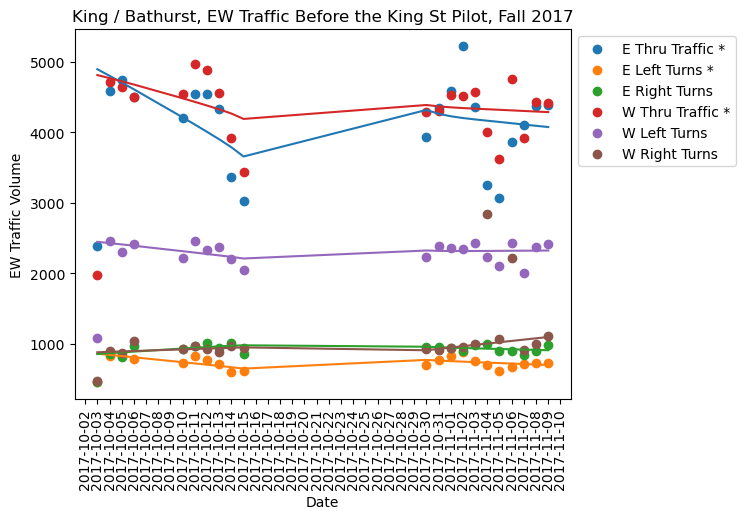

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = pd.to_datetime(resultPrePilot.index) # this is date

# data
etv = plt.scatter(x, resultPrePilot.e_thru_vol)
elv = plt.scatter(x, resultPrePilot.e_left_vol)
erv = plt.scatter(x, resultPrePilot.e_right_vol)
wtv = plt.scatter(x, resultPrePilot.w_thru_vol)
wlv = plt.scatter(x, resultPrePilot.w_left_vol)
wrv = plt.scatter(x, resultPrePilot.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify the it parameter
filtered = lowess(resultPrePilot.e_thru_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.e_left_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.e_right_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.w_thru_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.w_left_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPrePilot.w_right_vol, pd.to_datetime(resultPrePilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic Before the King St Pilot, Fall 2017')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
# plt.ylim(0, 4000)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

### Pilot

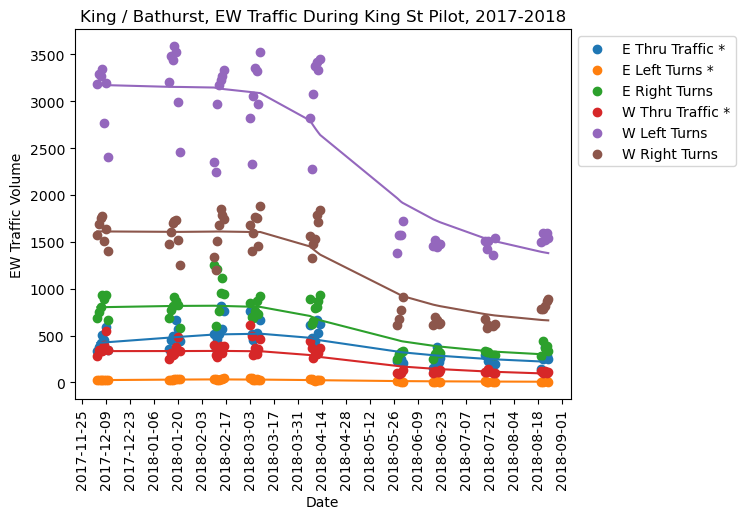

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

x = pd.to_datetime(resultPilot.index) # this is date

# data
etv = plt.scatter(x, resultPilot.e_thru_vol)
elv = plt.scatter(x, resultPilot.e_left_vol)
erv = plt.scatter(x, resultPilot.e_right_vol)
wtv = plt.scatter(x, resultPilot.w_thru_vol)
wlv = plt.scatter(x, resultPilot.w_left_vol)
wrv = plt.scatter(x, resultPilot.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify the it parameter
filtered = lowess(resultPilot.e_thru_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.e_left_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.e_right_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.w_thru_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.w_left_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(resultPilot.w_right_vol, pd.to_datetime(resultPilot.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic During King St Pilot, 2017-2018')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
# plt.ylim(0, 4000)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

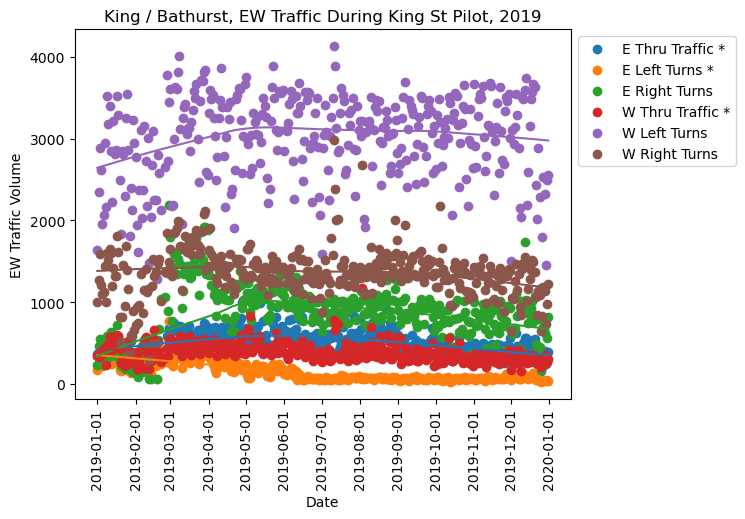

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2019.index) # this is date

# data
etv = plt.scatter(x, result2019.e_thru_vol)
elv = plt.scatter(x, result2019.e_left_vol)
erv = plt.scatter(x, result2019.e_right_vol)
wtv = plt.scatter(x, result2019.w_thru_vol)
wlv = plt.scatter(x, result2019.w_left_vol)
wrv = plt.scatter(x, result2019.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2019.e_thru_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.e_left_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.e_right_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.w_thru_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.w_left_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2019.w_right_vol, pd.to_datetime(result2019.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic During King St Pilot, 2019')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

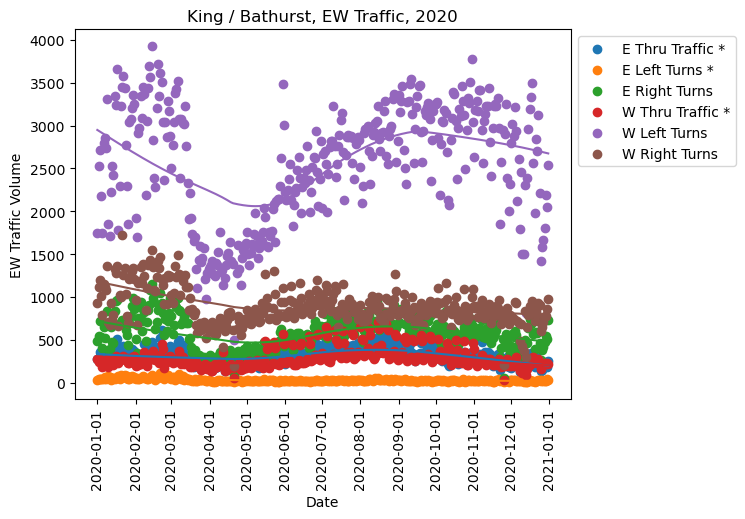

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2020.index) # this is date

# data
etv = plt.scatter(x, result2020.e_thru_vol)
elv = plt.scatter(x, result2020.e_left_vol)
erv = plt.scatter(x, result2020.e_right_vol)
wtv = plt.scatter(x, result2020.w_thru_vol)
wlv = plt.scatter(x, result2020.w_left_vol)
wrv = plt.scatter(x, result2020.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2020.e_thru_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.e_left_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.e_right_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.w_thru_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.w_left_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2020.w_right_vol, pd.to_datetime(result2020.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic, 2020')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

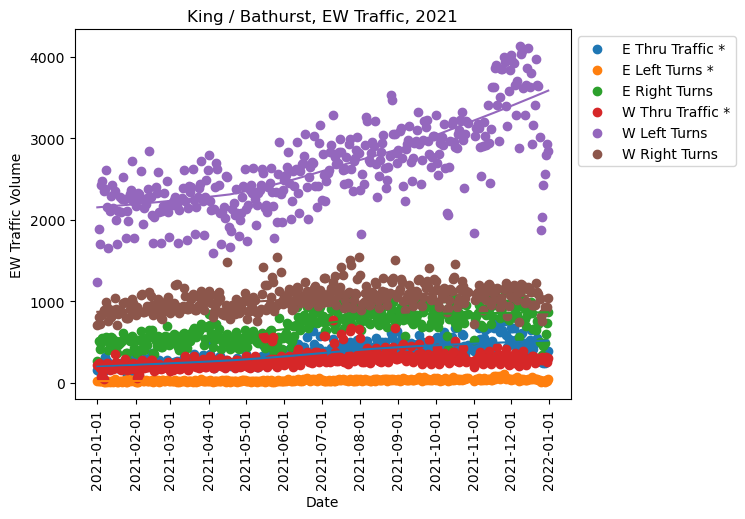

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2021.index) # this is date

# data
etv = plt.scatter(x, result2021.e_thru_vol)
elv = plt.scatter(x, result2021.e_left_vol)
erv = plt.scatter(x, result2021.e_right_vol)
wtv = plt.scatter(x, result2021.w_thru_vol)
wlv = plt.scatter(x, result2021.w_left_vol)
wrv = plt.scatter(x, result2021.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2021.e_thru_vol, pd.to_datetime(result2021.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2021.e_left_vol, pd.to_datetime(result2021.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2021.e_right_vol, pd.to_datetime(result2021.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2021.w_thru_vol, pd.to_datetime(result2021.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2021.w_left_vol, pd.to_datetime(result2021.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2021.w_right_vol, pd.to_datetime(result2021.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic, 2021')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

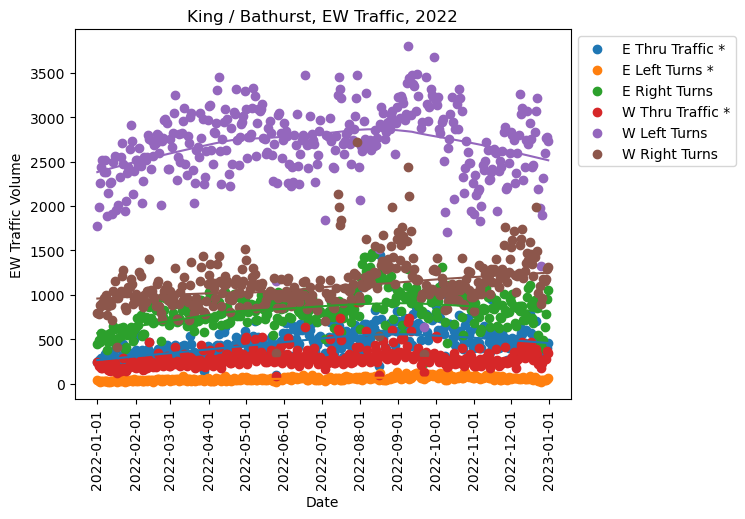

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2022.index) # this is date

# data
etv = plt.scatter(x, result2022.e_thru_vol)
elv = plt.scatter(x, result2022.e_left_vol)
erv = plt.scatter(x, result2022.e_right_vol)
wtv = plt.scatter(x, result2022.w_thru_vol)
wlv = plt.scatter(x, result2022.w_left_vol)
wrv = plt.scatter(x, result2022.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2022.e_thru_vol, pd.to_datetime(result2022.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2022.e_left_vol, pd.to_datetime(result2022.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2022.e_right_vol, pd.to_datetime(result2022.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2022.w_thru_vol, pd.to_datetime(result2022.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2022.w_left_vol, pd.to_datetime(result2022.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2022.w_right_vol, pd.to_datetime(result2022.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic, 2022')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
# plt.ylim(0, 4000)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

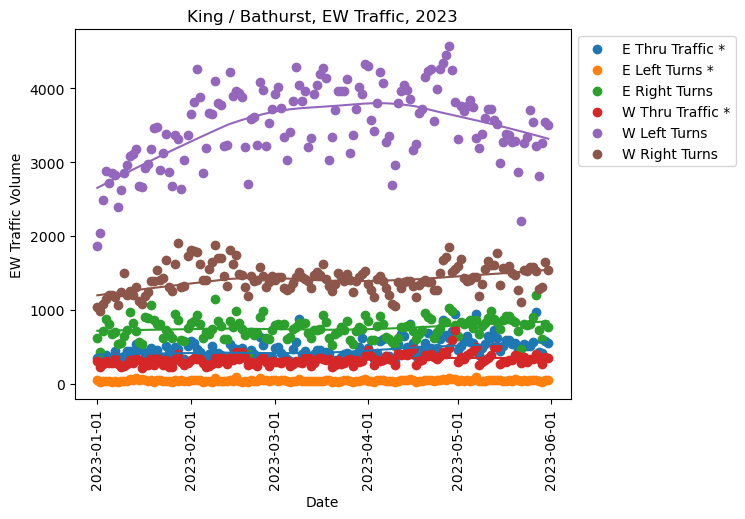

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
 
x = pd.to_datetime(result2023.index) # this is date

# data
etv = plt.scatter(x, result2023.e_thru_vol)
elv = plt.scatter(x, result2023.e_left_vol)
erv = plt.scatter(x, result2023.e_right_vol)
wtv = plt.scatter(x, result2023.w_thru_vol)
wlv = plt.scatter(x, result2023.w_left_vol)
wrv = plt.scatter(x, result2023.w_right_vol)

# creating LOWESS; frac too big is too smooth, too small is too sensitive and will overfit data
# frac usually 2./3
# people don't usually modify it parameter
filtered = lowess(result2023.e_thru_vol, pd.to_datetime(result2023.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2023.e_left_vol, pd.to_datetime(result2023.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2023.e_right_vol, pd.to_datetime(result2023.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2023.w_thru_vol, pd.to_datetime(result2023.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2023.w_left_vol, pd.to_datetime(result2023.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

filtered = lowess(result2023.w_right_vol, pd.to_datetime(result2023.index), is_sorted=True, frac= 3./5, it=3)
smoothedx = filtered[:,0].astype('datetime64[ns]')
smoothedy = filtered[:,1]
plt.plot(smoothedx, smoothedy)

# plot details
plt.legend((etv, elv, erv, wtv, wlv, wrv), 
           ("E Thru Traffic *", "E Left Turns *", "E Right Turns", "W Thru Traffic *", "W Left Turns", "W Right Turns"), 
           scatterpoints=1, bbox_to_anchor=(1, 1), loc='upper left')

plt.title('King / Bathurst, EW Traffic, 2023')
plt.xlabel('Date')
plt.ylabel('EW Traffic Volume')
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

## Plotly

In [42]:
fig = px.scatter(results, 
                 x="date", 
                 y=["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"], 
                 labels={
                     "date" : "Date", 
                     "value" : "Traffic Volume", 
                     "variable" : "Movement"}, 
                 trendline="lowess", 
                 trendline_options=dict(frac=0.3),
                 title="King / Bathurst, EW Traffic Volumes")

varlabels = {
    "e_thru_vol" : "E Thru Traffic *", 
    "e_left_vol" : "E Left Turns *", 
    "e_right_vol" : "E Right Turns", 
    "w_thru_vol" : "W Thru Traffic *", 
    "w_left_vol": "W Left Turns", 
    "w_right_vol" : "W Right Turns"}

fig.for_each_trace(lambda t: t.update(name = varlabels[t.name], 
                                      legendgroup = varlabels[t.name], 
                                      hovertemplate = t.hovertemplate.replace(t.name, varlabels[t.name])))
fig.show()

In [39]:
fig = px.scatter(results, 
                 x="doy", 
                 y=["e_thru_vol", "e_left_vol", "e_right_vol", "w_thru_vol", "w_left_vol", "w_right_vol"], 
                 labels={
                     "doy" : "Day of Year", 
                     "value" : "Traffic Volume", 
                     "variable" : "Movement",
                     "year" : "Year"}, 
                 trendline="lowess", 
                 trendline_options=dict(frac=0.6),
                 facet_col="year",
                 title="King / Bathurst, EW Traffic Volumes")

varlabels = {
    "e_thru_vol" : "E Thru Traffic *", 
    "e_left_vol" : "E Left Turns *", 
    "e_right_vol" : "E Right Turns", 
    "w_thru_vol" : "W Thru Traffic *", 
    "w_left_vol": "W Left Turns", 
    "w_right_vol" : "W Right Turns"}

fig.for_each_trace(lambda t: t.update(name = varlabels[t.name], 
                                      legendgroup = varlabels[t.name], 
                                      hovertemplate = t.hovertemplate.replace(t.name, varlabels[t.name])))
fig.show()